<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/SHAP%26Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Install & Imports
!pip install shap

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load Data & Model

#  Load Data
data_path = '/content/drive/My Drive/instacart_train_data.pkl'
print(f"Loading data from {data_path}...")
df = pd.read_pickle(data_path)

#  Prepare X and y
features_to_drop = ['reordered', 'eval_set', 'user_id', 'product_id', 'order_id']
X = df.drop([c for c in features_to_drop if c in df.columns], axis=1)
y = df['reordered']

#  Create a Sample for SHAP
print("Creating a sample for analysis (5,000 rows)...")
X_sample = X.sample(5000, random_state=42)
y_sample = y.loc[X_sample.index]

# Load or Re-train Model
# We train a quick XGBoost model here to ensure the explanation code works.
print("Training helper model for explanation...")
model = xgb.XGBClassifier(enable_categorical=True, tree_method='hist', device='cpu')
model.fit(X_sample, y_sample)
print("Model ready.")

Loading data from /content/drive/My Drive/instacart_train_data.pkl...
Creating a sample for analysis (5,000 rows)...
Training helper model for explanation...
Model ready.


In [3]:
#  Train Helper Model

print("Training XGBoost model on sample...")
# We use 'hist' method which is faster and uses less memory
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    tree_method='hist',
    enable_categorical=True,
    device='cpu'
)

model.fit(X_sample, y_sample)
print("Model trained successfully.")

Training XGBoost model on sample...
Model trained successfully.


Calculating SHAP values...


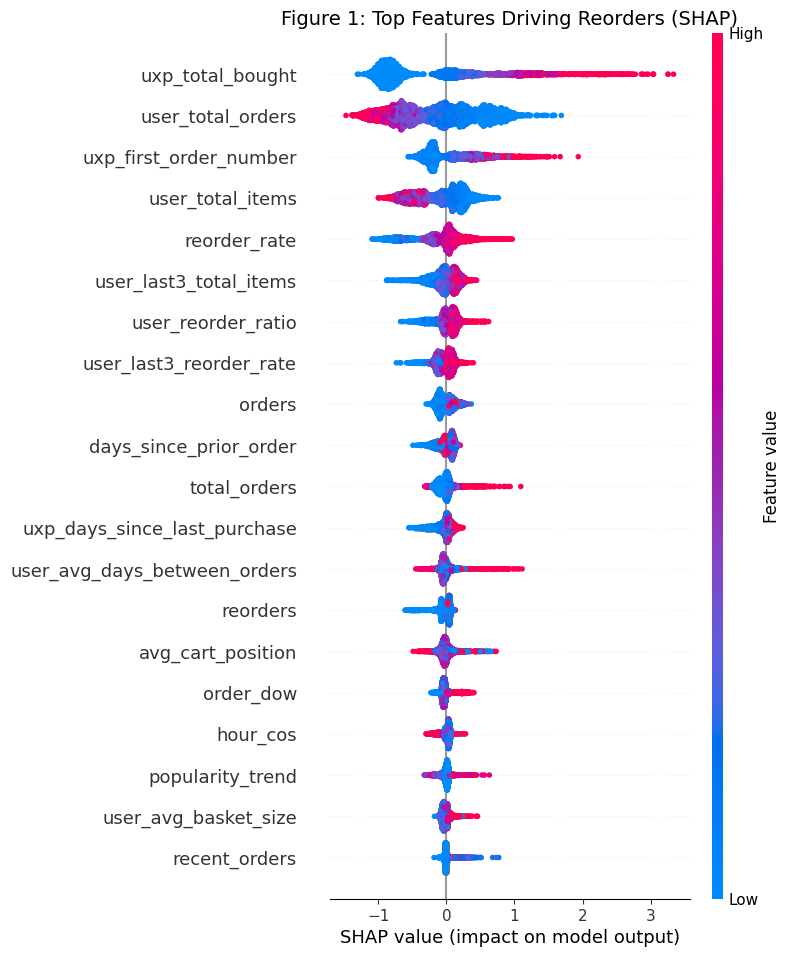

In [4]:
# SHAP Summary Plot

print("Calculating SHAP values...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Figure 1: Top Features Driving Reorders (SHAP)", fontsize=14)
plt.show()

Plotting dependence for: days_since_prior_order


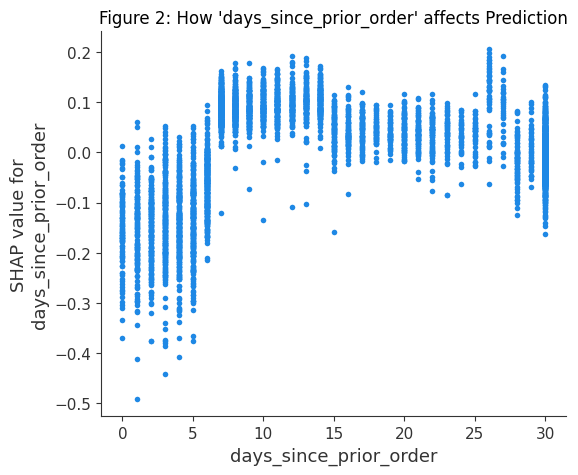

In [5]:
# SHAP Dependence Plot

feature = 'days_since_prior_order'

if feature in X_sample.columns:
    print(f"Plotting dependence for: {feature}")
    shap.dependence_plot(feature, shap_values, X_sample, interaction_index=None, show=False)
    plt.title(f"Figure 2: How '{feature}' affects Prediction", fontsize=12)
    plt.show()

Injecting noise to stress-test the model...


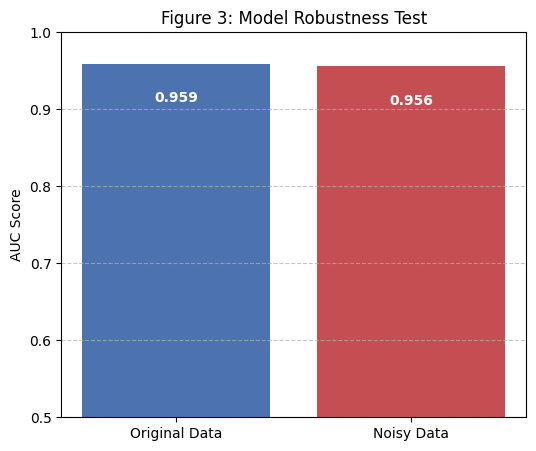

Performance Drop: 0.0032
VERDICT: Robust (Safe to deploy)


In [6]:
# Robustness Check & Figure

# Baseline Score
base_preds = model.predict_proba(X_sample)[:, 1]
base_auc = roc_auc_score(y_sample, base_preds)

# Inject Noise (Simulate bad data)
# We add noise to 'days_since_prior_order'
print("Injecting noise to stress-test the model...")
X_noisy = X_sample.copy()
sigma = X_noisy['days_since_prior_order'].std()
noise = np.random.normal(0, sigma * 0.5, size=len(X_noisy)) # 50% noise
X_noisy['days_since_prior_order'] += noise

# Noisy Score
noisy_preds = model.predict_proba(X_noisy)[:, 1]
noisy_auc = roc_auc_score(y_sample, noisy_preds)

# Robustness Comparison
scores = [base_auc, noisy_auc]
labels = ['Original Data', 'Noisy Data']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, scores, color=['#4c72b0', '#c44e52'])
plt.ylim(0.5, 1.0)
plt.ylabel('AUC Score')
plt.title('Figure 3: Model Robustness Test')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
             f'{score:.3f}', ha='center', color='white', fontweight='bold')

plt.show()

print(f"Performance Drop: {base_auc - noisy_auc:.4f}")
if (base_auc - noisy_auc) < 0.05:
    print("VERDICT: Robust (Safe to deploy)")
else:
    print("VERDICT: Fragile (Needs retraining)")